In [1]:
from numpy import *
from matplotlib import pyplot as plt
import scipy.integrate as integrate
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


# Model
## Define some global cosntants and materials

In [2]:
global NA, Rc, T, kB, h, ve, ligand, chloroform, air, graphene, Fe3O4
NA=6.02214076E23
Rc=8.314                  #J·K^−1·mol^−1
T=298.15                 #K
kB=1.38*10.**(-23.)      #J/K, Boltzmann constant
h_pc=6.62607004*10.**(-34.) #J.s, Planck constant
ve=3.*10.**15.           #s-1, electronic absorption frequency


class Material:
    def __init__(self):
        pass

    # cal A: non-retard Hamaker constant,
    def cal_A(self):
        e0=1.                    # Dielectric Constant of vacuum
        n0=1.                    # refractive index of vacuum
        A0=3./4.*kB*T*((self.e-e0)/(self.e+e0))**2.
        A1=3*h_pc*ve*(self.n**2-n0**2.)**2/(16.*sqrt(2.)*(self.n**2.+n0**2.)**(3./2.))
        return (A0+A1)/kB/T
    
    
ligand=Material()
ligand.MW=282.5                       #g/mol
ligand.rho=0.89*1E-21                 #g/nm^3
ligand.per_V=ligand.MW/NA/ligand.rho  #nm^3
ligand.sol=15.8                      #MPa^1/2
ligand.e=2.5
ligand.n=1.38
ligand.A=ligand.cal_A()
ligand.L=2.0
ligand.Comp_Mod=2.43E2               #Compressive Modulus (kBT/nm3)


chloroform=Material()
chloroform.sol=19.0                   #MPa^1/2
chloroform.MolarV=80.70               #cm^3·mol^−1
chloroform.Vs=chloroform.MolarV*1E21/NA #nm^3
chloroform.e=4.39
chloroform.n=1.44
chloroform.A=chloroform.cal_A()


air=Material()
air.sol=0.                             #MPa^1/2
air.MolarV=22400.0                     #cm^3·mol^−1
air.Vs=air.MolarV*1E21/NA              #nm^3
air.e=1.0
air.n=1.0
air.A=air.cal_A()
 
graphene=Material()
graphene.e=6.9
graphene.n=2.70
graphene.A=graphene.cal_A()
graphene.s=0.335

mxene=Material()
mxene.e=25
mxene.n=5.0
mxene.A=mxene.cal_A()
mxene.s=0.98

Fe3O4=Material()
Fe3O4.e=30.0
Fe3O4.n=2.36
Fe3O4.A=Fe3O4.cal_A()

The interaction between layer can be consider as:
$$ U=U_{osm}+U_{ela}+U_{vdW}, $$

## Osmotic and elastic interaction in solvent and compression part in air

Here calculate some parameters:
\begin{equation}
\chi_{1-2}=\frac{\left(\delta_{1}-\delta_{2}\right)^{2} V_{s}}{R T}
\end{equation}

$U_{osm}$ between two plates with separated $h$ are: 
\begin{equation}
U_{osm}^{W}=
\left\{ 
\begin{aligned}
&0, & \quad 2L\leq h \\
&\frac{2k_BT}{V_s}\phi_{L1}\phi_{L2}(\frac{1}{2}-\chi)(2L-h),& \quad  L\leq h < 2L\\
&\frac{2k_BT}{V_s}\phi_{L1}\phi_{L2}(\frac{1}{2}-\chi)(\frac{3L^2}{h}-2L), & \quad h<L,
\end{aligned}
\right.
\end{equation}

$U_{osm}$ between two sphere (radius R and $\infty$) with separated $h$ are: 
\begin{equation}
U_{osm}^{SW}=
\left\{ 
\begin{aligned}
&0, & \quad 2L\leq h \\
&\frac{8\pi k_BT R}{V_s}\phi_{L1}\phi_{L2}(\frac{1}{2}-\chi)(L-\frac{h}{2})^2,& \quad  L\leq h < 2L\\
&\frac{8\pi k_BT R}{V_s}\phi_{L1}\phi_{L2}(\frac{1}{2}-\chi) L^2\left(\frac{h}{2L}-\frac{1}{4}-\ln\left(\frac{h}{L}\right) \right), & \quad h<L,
\end{aligned}
\right.
\end{equation}

$U_{osm}$ between two sphere (radius $R$ and $R$) with separated $h$ are: 
\begin{equation}
U_{osm}^{SS}=
\left\{ 
\begin{aligned}
&0, & \quad 2L\leq h \\
&\frac{4\pi k_BT R}{V_s}\phi_{L}^2(\frac{1}{2}-\chi)(L-\frac{h}{2})^2,& \quad  L\leq h < 2L\\
&\frac{4\pi k_BT R}{V_s}\phi_{L}^2(\frac{1}{2}-\chi) L^2\left(\frac{h}{2L}-\frac{1}{4}-\ln\left(\frac{h}{L}\right) \right), & \quad h<L,
\end{aligned}
\right.
\end{equation}


$U_{ela}$ between two plates with separated $h$ are: 
\begin{equation}
U_{ela}^{W}=
\left\{ 
\begin{aligned}
&0, & \quad L\leq h \\
&\frac{ 2k_BT\rho_{\mathrm{L}}}{M_{\mathrm{W}}} (\phi_{L1}+\phi_{L2})   \left[\frac{\left( \frac{h}{L}\right)^2-1}{2}-\ln \frac{h}{L} \right],  & \quad h<L,
\end{aligned}
\right.
\end{equation}


$U_{ela}$ between two sphere (radius $R$ and $\infty$) with separated $h$ are: 
\begin{equation}
U_{ela}^{SW}=
\left\{ 
\begin{aligned}
&0, & \quad L\leq h \\
&\frac{2\pi k_BT\rho_{\mathrm{L}}R}{M_{\mathrm{W}}} (\phi_{L1}+\phi_{L2}) L^{2}  \left[\frac{h}{L} \ln \left(\frac{h}{L}\left(\frac{3-h / L}{2}\right)^{2}\right)-6 \ln \left(\frac{3-h / L}{2}\right)+3\left(1+\frac{h}{L}\right)\right],  & \quad h<L,
\end{aligned}
\right.
\end{equation}

$U_{ela}$ between two sphere (radius $R$ and $R$) with separated $h$ are: 
\begin{equation}
U_{ela}^{SS}=
\left\{ 
\begin{aligned}
&0, & \quad L\leq h \\
&\frac{2\pi k_BT\rho_{\mathrm{L}}R}{M_{\mathrm{W}}} \phi_{L} L^{2}  \left[\frac{h}{L} \ln \left(\frac{h}{L}\left(\frac{3-h / L}{2}\right)^{2}\right)-6 \ln \left(\frac{3-h / L}{2}\right)+3\left(1+\frac{h}{L}\right)\right],  & \quad h<L,
\end{aligned}
\right.
\end{equation}

In [3]:
import scipy.integrate as integrate
class Ligand_Layer:
    def __init__(self,ligand,solvent,coat_rho1,coat_rho2,h,R):
        self.ligand=ligand
        self.solvent=solvent
        self.coat_rho1=coat_rho1
        self.coat_rho2=coat_rho2
        self.h=h
        self.L=self.ligand.L
        self.R=R
        self.phi1=self.cal_phi_ligand(coat_rho1)
        self.phi2=self.cal_phi_ligand(coat_rho2)
        self.FH=self.cal_FH()
        self.e=self.cal_mixed_diel()
        self.n=self.cal_mixed_refrac()
        self.A=self.cal_A()
        self.h_min=self.cal_h_min()
        
        
    #rho_area: number of ligands per nm2    
    def cal_phi_ligand(self,coat_rho): 
        phi=coat_rho*self.ligand.per_V/self.h
        if phi<1.:
            return phi
        else:
            return 1.    
    
    def cal_h_min(self):
        return (self.coat_rho1+self.coat_rho2)*self.ligand.per_V
        
   #Flory–Huggins interaction parameter
    def cal_FH(self):
        return (self.ligand.sol-self.solvent.sol)**2*self.solvent.MolarV/Rc/T    
    
    #cal mixed dielectric constant
    def cal_mixed_diel(self):
        phi=self.phi1+self.phi2
        if phi>1:
            phi=1
        return exp(phi*log(self.ligand.e)+(1-phi)*log(self.solvent.e))

    #cal mixed refractive index
    def cal_mixed_refrac(self):
        phi=self.phi1+self.phi2
        if phi>1:
            phi=1
        return phi*self.ligand.n+(1-phi)*self.solvent.n
    
    # cal A: non-retard Hamaker constant,
    def cal_A(self):
        e0=1.                    # Dielectric Constant of vacuum
        n0=1.                    # refractive index of vacuum
        A0=3./4.*kB*T*((self.e-e0)/(self.e+e0))**2.
        A1=3*h_pc*ve*(self.n**2-n0**2.)**2/(16.*sqrt(2.)*(self.n**2.+n0**2.)**(3./2.))
        return (A0+A1)/kB/T
    
    def update_A(self,h):
        self.h=h
        self.phi1=self.cal_phi_ligand(self.coat_rho1)
        self.phi2=self.cal_phi_ligand(self.coat_rho2)
        self.e=self.cal_mixed_diel()
        self.n=self.cal_mixed_refrac()
        self.A=self.cal_A()
        self.h_min=self.cal_h_min()
        
    def cal_U_osm_W(self):
        if 2*self.L<=self.h:
            return 0.
        if self.L<=self.h and self.h<2*self.L:
            return 2/self.solvent.Vs*self.phi1*self.phi2*(1./2.-self.FH)*(2*self.L-self.h)
        if self.h<self.L:
            return 2/self.solvent.Vs*self.phi1*self.phi2*(1./2.-self.FH)*(3*self.L*self.L/self.h-2*self.L)

    def cal_U_osm_SW(self):
        if 2*self.L<=self.h:
            return 0.
        if self.L<=self.h and self.h<2*self.L:
            return 8*pi*self.R/self.solvent.Vs*self.phi1*self.phi2*(1./2.-self.FH)*(self.L-self.h/2.)**2
        if self.h<self.L:
            return 8*pi*self.R/self.solvent.Vs*self.phi1*self.phi2*(1./2.-self.FH)*self.L*self.L*(self.h/2./self.L-1./4.-log(self.h/self.L))

    def cal_U_osm_SS(self):
        if 2*self.L<=self.h:
            return 0.
        if self.L<=self.h and self.h<2*self.L:
            return 4*pi*self.R/self.solvent.Vs*self.phi1*self.phi2*(1./2.-self.FH)*(self.L-self.h/2.)**2
        if self.h<self.L:
            return 4*pi*self.R/self.solvent.Vs*self.phi1*self.phi2*(1./2.-self.FH)*self.L*self.L*(self.h/2./self.L-1./4.-log(self.h/self.L))    

    def cal_U_ela_W(self):
        if self.L<=self.h:
            return 0
        if self.h<self.L:
            rho_update=self.ligand.rho
            if self.h<self.h_min:
                rho_update=self.ligand.rho*self.h_min/self.h
            return 2*rho_update*NA/self.ligand.MW*(self.phi1+self.phi2)*(((self.h/self.L)**2-1.)/2.-log(self.h/self.L))

    def cal_U_ela_SW(self):
        if self.L<=self.h:
            return 0
        if self.h<self.L:
            rho_update=self.ligand.rho
            if self.h<self.h_min:
                rho_update=self.ligand.rho*self.h_min/self.h
            return 2*pi*rho_update*self.R*NA*(self.phi1+self.phi2)/self.ligand.MW*self.L*self.L*(self.h/self.L*log(self.h/self.L*((3.-self.h/self.L)/2.)**2)-6.*log((3.-self.h/self.L)/2.)+3.*(1.-self.h/self.L))

    def cal_U_ela_SS(self):
        if self.L<=self.h:
            return 0
        if self.h<self.L:
            rho_update=self.ligand.rho
            if self.h<self.h_min:
                rho_update=self.ligand.rho*self.h_min/self.h
            return 2*pi*rho_update*self.R*NA*self.phi1/self.ligand.MW*self.L*self.L*(self.h/self.L*log(self.h/self.L*((3.-self.h/self.L)/2.)**2)-6.*log((3.-self.h/self.L)/2.)+3.*(1.-self.h/self.L))      
        
    def cal_U_ela_SS_derjaguin(self):
        if self.L<=self.h:
            return 0
        x_max=sqrt(self.R**2-(self.h/2+self.R-self.L/2)**2)
        def cal_unit(x):
            h_prime=self.h+2*self.R-2*sqrt(self.R**2-x**2)
            if self.L<=h_prime:
                return 0
            if h_prime<self.L:
                rho_update=self.ligand.rho
                if self.h<self.h_min:
                    rho_update=self.ligand.rho*self.h_min/self.h
                return 2*pi*x*2*rho_update*NA/self.ligand.MW*(self.phi1+self.phi2)*(((h_prime/self.L)**2-1.)/2.-log(h_prime/self.L))
        return integrate.quad(cal_unit,0,x_max)[0]

    def cal_U_com_W(self):
        if self.h_min<=self.h:
            return 0
        else:
            return 1./2.*self.ligand.Comp_Mod/self.h_min*(self.h_min-self.h)**2
    
    def cal_U_com_SW(self):
        if self.h_min<=self.h:
            return 0
        x_max=sqrt(self.R**2-(self.h+self.R-self.h_min)**2)
        def cal_unit(x):
            h_prime=self.h+self.R-sqrt(R**2-x**2)
            if self.h_min<=h_prime:
                return 0
            else:
                return 2*pi*x*1./2.*self.ligand.Comp_Mod/self.h_min*(self.h_min-h_prime)**2
        return integrate.quad(cal_unit,0,x_max)[0]
        
    def cal_U_com_SS(self):
        if self.h_min<=self.h:
            return 0       
        x_max=sqrt(self.R**2-(self.h/2+self.R-self.h_min/2)**2)
        def cal_unit(x):
            h_prime=self.h+2*self.R-2*sqrt(R**2-x**2)
            if self.h_min<=h_prime:
                return 0
            else:
                return 2*pi*x*1./2.*self.ligand.Comp_Mod/self.h_min*(self.h_min-h_prime)**2
        return integrate.quad(cal_unit,0,x_max)[0]
        

## Calculation of van der Waals interaction for two objects

$$ A_{AB/CD}=(A_{A}-A_{B})(A_{C}-A_{D}) $$

$$A_{i}=\frac{3}{4} k_{B} T\left(\frac{\varepsilon_{i}-\varepsilon_{0}}{\varepsilon_{i}+\varepsilon_{0}}\right)^{2}+\frac{3 h v_{e}\left(n_{i}^{2}-n_{0}^{2}\right)^{2}}{16 \sqrt{2}\left(n_{i}^{2}+n_{0}^{2}\right)^{3 / 2}}$$


$$U_{vdW}^{W}(A,h)=-\frac{A}{12\pi h^2}$$

$$ U_{vdW}^{SW}(A,h)=-\frac{A}{6}\left(\frac{\mathrm{R}}{h}+\frac{\mathrm{R}}{2 \mathrm{R}+h}+\ln \frac{h}{2 \mathrm{R}+h}\right) $$

$$ U_{vdW}^{SS}(A,d)= -\frac{A}{3}\left[\frac{{R}^{2}}{d^{2}-4 {R}^{2}}+\frac{{R}^{2}}{d^{2}}+\frac{1}{2} \ln \left(1-\frac{4 {R}^{2}}{d^{2}}\right)\right]$$

$$U_{vdW}^{GG}=U_{vdW}^{W}(A_{GL/GL},h)+2U_{vdW}^{W}(A_{MG/GL},h+s_G)+U_{vdW}^{W}(A_{MG/MG},h+2s_G)$$
$$U_{vdW}^{GS}=U_{vdW}^{SW}(A_{PL/GL},h)+U_{vdW}^{SW}(A_{PL/MG},h+s_G)$$
$$U_{vdW}^{GG}=U_{vdW}^{SS}(A_{PL/PL},h+2R) $$

In [4]:
class Interface_pair:
    def __init__(self,m1,m2,m3,m4,h,R):
        self.m1=m1
        self.m2=m2
        self.m3=m3
        self.m4=m4
        self.A=self.cal_hybrid_A()
        self.R=R
        self.h=h
        
    # cal hybird A of interface AB and CD, B and D are inner interface
    def cal_hybrid_A(self):
        return (sqrt(self.m1.A)-sqrt(self.m2.A))*(sqrt(self.m3.A)-sqrt(self.m4.A))
    
    def cal_U_vdW_W(self):
        return -self.A/12./pi/self.h/self.h

    def cal_U_vdW_SW(self):
        return -self.A/6.*(self.R/self.h+self.R/(2.*self.R+self.h)+log(self.h/(2.*self.R+self.h)))
    
    def cal_U_vdW_SS(self):
        d=2*self.R+self.h
        return -self.A/3.*(self.R*self.R/(d**2-4*self.R**2)+self.R*self.R/d/d+1./2.*log(1.-4*self.R*self.R/d/d))
    
    def cal_U_vdW_SS_derjaguin(self):
        def cal_unit(x):
            h_prime=h+2*R-2*sqrt(R**2-x**2)
            return 2*pi*x*(-self.A/12./pi/h_prime/h_prime)
        return integrate.quad(cal_unit,0,R)[0]

def cal_U_vdW_GG(graphene,ligand_layer,media,h):
    GL_GL=Interface_pair(graphene,ligand_layer,graphene,ligand_layer,h,0)
    MG_GL=Interface_pair(media,graphene,graphene,ligand_layer,h+graphene.s,0)
    MG_MG=Interface_pair(media,graphene,media,graphene,h+2*graphene.s,0)
    return GL_GL.cal_U_vdW_W()+2*MG_GL.cal_U_vdW_W()+MG_MG.cal_U_vdW_W()
    
def cal_U_vdW_GP(graphene,particle,ligand_layer,media,h,R):
    PL_GL=Interface_pair(particle,ligand_layer,graphene,ligand_layer,h,R)
    PL_MG=Interface_pair(particle,ligand_layer,media,graphene,h+graphene.s,R)
    return PL_GL.cal_U_vdW_SW()+PL_MG.cal_U_vdW_SW()
    #return cal_U_vdW_GP_unfix_layer(graphene,particle,ligand_layer,media,h,R)

def cal_U_vdW_PP(particle,ligand_layer,h,R):
    #PL_PL=Interface_pair(particle,ligand_layer,particle,ligand_layer,h,R)
    #return PL_PL.cal_U_vdW_SS()
    return cal_U_vdW_PP_unfix_layer(particle,ligand_layer,h,R)

def cal_U_vdW_GP_unfix_layer(graphene,particle,ligand_layer,media,h,R):
    def cal_unit(x,graphene,particle,ligand_layer,media,h,R):
        h_prime=h+R-sqrt(R**2-x**2)
        ligand_layer.update_A(h_prime)
        PL_GL=Interface_pair(particle,ligand_layer,graphene,ligand_layer,h_prime,R)
        PL_MG=Interface_pair(particle,ligand_layer,media,graphene,h_prime+graphene.s,R)
        return 2*pi*x*(PL_GL.cal_U_vdW_W()+PL_MG.cal_U_vdW_W())
    U=integrate.quad(cal_unit,0,R,args=(graphene,particle,ligand_layer,media,h,R))[0]
    ligand_layer.update_A(h)
    return U

def cal_U_vdW_PP_unfix_layer(particle,ligand_layer,h,R):
    def cal_unit(x,particle,ligand_layer,h,R):
        h_prime=h+2*R-2*sqrt(R**2-x**2)
        ligand_layer.update_A(h_prime)
        PL_PL=Interface_pair(particle,ligand_layer,particle,ligand_layer,h_prime,R)
        return 2*pi*x*PL_PL.cal_U_vdW_W()
    U=integrate.quad(cal_unit,0,R,args=(particle,ligand_layer,h,R))[0]
    ligand_layer.update_A(h)
    return U



## Calculation of interaction between two ligand layers in air (after evaporation)

In [5]:
class Ligand_vdW:
    def __init__(self,ligand,coat_rho1,coat_rho2,h):
        self.ligand=ligand;
        self.coat_rho1=coat_rho1;
        self.coat_rho2=coat_rho2;
        self.h=h;
        self.A=-(1.34)/NA/(9.83*10**(-22))  #kbT/NA/nm^6 cal/unit/kT,(9.83×10−22 cal)
        self.lamb=0.127         
        self.D=0.49                     #close-packing separation distance
        self.active_area=1.
        
    def cal_pair_ligand_vdW(self,overlap_L):
        return self.A*3.*pi/8./(self.lamb**2)*overlap_L/(self.D**5)
        
    def cal_WW_vdW(self,h):
        if h>2*self.ligand.L:
            return 0
        elif self.h<=2*self.ligand.L:
            overlap_L=2*self.ligand.L-h
            return self.active_area*self.coat_rho1*self.coat_rho2*self.cal_pair_ligand_vdW(overlap_L)
        #elif h<self.ligand.L:
        #    coat_rho1_mod=self.coat_rho1*self.ligand.L/h
        #    coat_rho2_mod=self.coat_rho2*self.ligand.L/h
        #    return self.active_area*coat_rho1_mod*coat_rho2_mod*self.cal_pair_ligand_vdW(h)
    
    def cal_SS_vdW(self,R):
        if self.h>2*self.ligand.L:
            return 0
        def cal_unit(x):
            h_prime=self.h+2*R-2*sqrt(R*R-x*x)
            return self.cal_WW_vdW(h_prime)
        x_max=sqrt(R**2-(R+self.h/2.-self.ligand.L)**2)
        return integrate.quad(cal_unit,0,x_max)[0]
        
    def cal_SW_vdW(self,R):
        if self.h>2*self.ligand.L:
            return 0
        def cal_unit(x):
            h_prime=self.h+R-sqrt(R*R-x*x)
            return self.cal_WW_vdW(h_prime)
        x_max=sqrt(R**2-(R+self.h-2*self.ligand.L)**2)
        return integrate.quad(cal_unit,0,x_max)[0]


## Calculate the overall interactions

In [6]:
#calculate interaction between particle and particle in solvents
def cal_U_PP(particle,ligand,solvent,coat_rho,h,R):
    ligand_layer=Ligand_Layer(ligand,solvent,coat_rho,coat_rho,h,R)
    U_layer=ligand_layer.cal_U_osm_SS()+ligand_layer.cal_U_ela_SS()
    U_vdW=cal_U_vdW_PP(particle,ligand_layer,h,R)
    return U_layer+U_vdW

def cal_U_GG(graphene,ligand,solvent,coat_rho,h,R):
    ligand_layer=Ligand_Layer(ligand,solvent,coat_rho,coat_rho,h,R)
    U_layer=ligand_layer.cal_U_osm_W()+ligand_layer.cal_U_ela_W()#+ligand_layer.cal_U_com_W()
    U_vdW=cal_U_vdW_GG(graphene,ligand_layer,solvent,h)
    return U_layer+U_vdW

def cal_U_GP(graphene,particle,ligand,solvent,coat_rho_P,coat_rho_G,h,R):
    ligand_layer=Ligand_Layer(ligand,solvent,coat_rho_P,coat_rho_G,h,R)
    U_layer=ligand_layer.cal_U_osm_SW()+ligand_layer.cal_U_ela_SW()#+ligand_layer.cal_U_com_SW()
    U_vdW=cal_U_vdW_GP(graphene,particle,ligand_layer,solvent,h,R)
    area=2*sqrt(3)*(R+1.5)**2
    return (U_layer+U_vdW)/area

def cal_U_PP_air(particle,ligand,solvent,coat_rho,h,R):
    ligand_layer=Ligand_Layer(ligand,solvent,coat_rho,coat_rho,h,R)
    ligand_vdW=Ligand_vdW(ligand,coat_rho,coat_rho,h)
    U_layer=ligand_vdW.cal_SS_vdW(R)+ligand_layer.cal_U_ela_SS()+ligand_layer.cal_U_com_SS()
    U_vdW=cal_U_vdW_PP(particle,ligand_layer,h,R)
    return U_layer+U_vdW

def cal_U_GG_air(graphene,ligand,solvent,coat_rho,h,R):
    ligand_layer=Ligand_Layer(ligand,solvent,coat_rho,coat_rho,h,R)
    ligand_vdW=Ligand_vdW(ligand,coat_rho,coat_rho,h)
    U_layer=ligand_layer.cal_U_com_W()+ligand_vdW.cal_WW_vdW(h)#+ligand_layer.cal_U_ela_W()
    U_vdW=cal_U_vdW_GG(graphene,ligand_layer,solvent,h)
    return U_layer+U_vdW

def cal_U_GP_air(graphene,particle,ligand,solvent,coat_rho_P,coat_rho_G,h,R):
    ligand_layer=Ligand_Layer(ligand,solvent,coat_rho_P,coat_rho_G,h,R)
    ligand_vdW=Ligand_vdW(ligand,coat_rho_P,coat_rho_G,h)
    U_layer=ligand_vdW.cal_SW_vdW(R)+ligand_layer.cal_U_com_SW()#+ligand_layer.cal_U_ela_SW()
    U_vdW=cal_U_vdW_GP(graphene,particle,ligand_layer,solvent,h,R)
    area=2*sqrt(3)*R**2
    return (U_layer+U_vdW)


# Section 1: Interactions in solvent and in air

## 1.1 $U_{GG}$ and $U_{GP}$ in different $\rho_{PL}$ in solvent
considering $R\gg h$, we assume the constant distance $h$ between particles are 3nm.

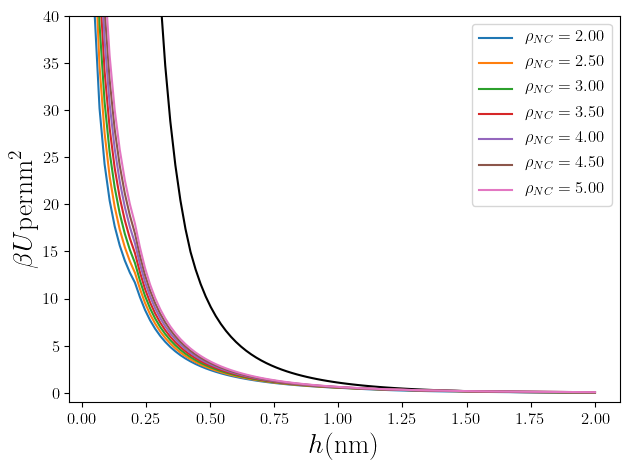

In [15]:
R=7
coat_rho_Ps=[2.0,2.5,3.0,3.5,4.0,4.5,5.0]
coat_rho_G=0.4
hs=linspace(0.05,2.0,100)
U_WWs=[]
data=hs

for h in hs:
    U_WW=cal_U_GG(graphene,ligand,chloroform,coat_rho_G,h,R)  
    U_WWs.append(U_WW)
plt.plot(hs,U_WWs,color="black")
data=column_stack((data,array(U_WWs)))

for coat_rho_P in coat_rho_Ps:
    U_SWs=[]
    for h in hs:
        U_SW=cal_U_GP(graphene,Fe3O4,ligand,chloroform,coat_rho_P,coat_rho_G,h,R)
        #U_SW=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)
        U_SWs.append(U_SW)
    plt.plot(hs,U_SWs,label=r'$\rho_{NC}=%.2f$'%(coat_rho_P))
    data=column_stack((data,array(U_SWs)))
plt.ylim(-1, 40.0)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U \rm{per} \mathrm{nm^2}$",fontsize=20)
plt.xlabel(r"$h(\mathrm{nm})$",fontsize=20)
plt.tight_layout()

## 1.2 $U_{PG}$ in different $\rho_{PL}$ in air

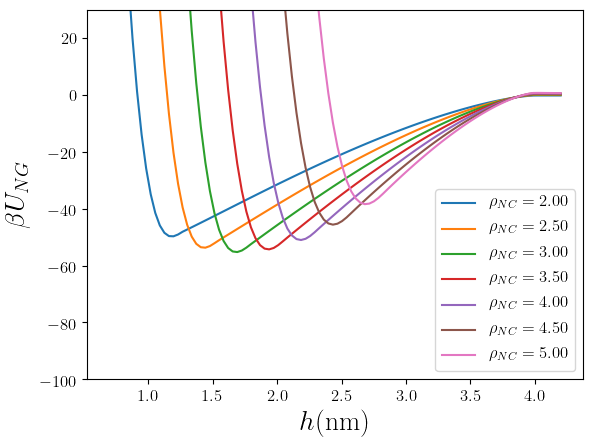

In [14]:
R=7
coat_rho_Ps=[2.0,2.5,3.0,3.5,4.0,4.5,5.0]
coat_rho_G=0.4
#coat_rho_Ps=[2.0]
#coat_rho_G=2
hs=linspace(0.7,4.2,100)
U_WWs=[]
data=hs
for coat_rho_P in coat_rho_Ps:
    U_SWs=[]
    for h in hs:
        U_SW=cal_U_GP_air(graphene,Fe3O4,ligand,air,coat_rho_P,coat_rho_G,h,R)
        #U_SW=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)
        U_SWs.append(U_SW)
    plt.plot(hs,U_SWs,label=r'$\rho_{NC}=%.2f$'%(coat_rho_P))
    data=column_stack((data,array(U_SWs)))
plt.ylim(-100,30)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U_{NG}$",fontsize=20)
plt.xlabel(r"$h (\mathrm{nm})$",fontsize=20)

## 1.3 $U_{PP}$ in different $\rho_{PL}$ in air

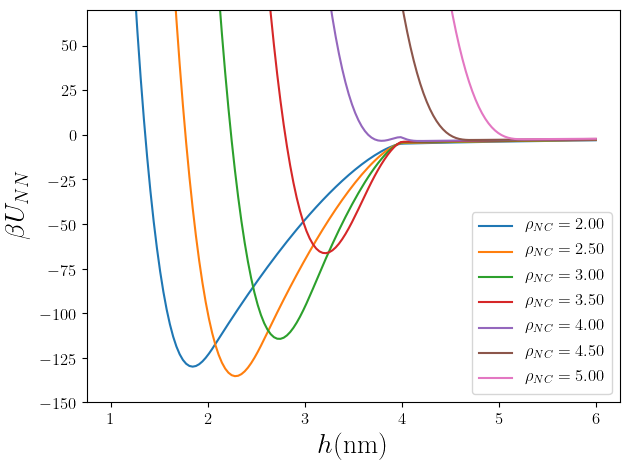

In [16]:
coat_rhos=[2.0,2.5,3.0,3.5,4.0,4.5,5.0]
#coat_rhos=[4.0]
R=7
hs=linspace(1,6,150)
data=hs

for coat_rho in coat_rhos:
    U1s=[]
    U2s=[]
    U3s=[]
    for h in hs:
        U1=cal_U_PP_air(Fe3O4,ligand,air,coat_rho,h,R)  
        U1s.append(U1)
    plt.plot(hs,U1s,label=r'$\rho_{NC}=%.2f$'%(coat_rho))
    data=column_stack((data,array(U1s)))
plt.ylim(-150, 70)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U_{NN}$",fontsize=20)
plt.xlabel(r"$h (\mathrm{nm})$",fontsize=20)
plt.tight_layout()

# Section 2: Interaction profile and Effect of solvent


## 2.1 graphene-graphene in solvent

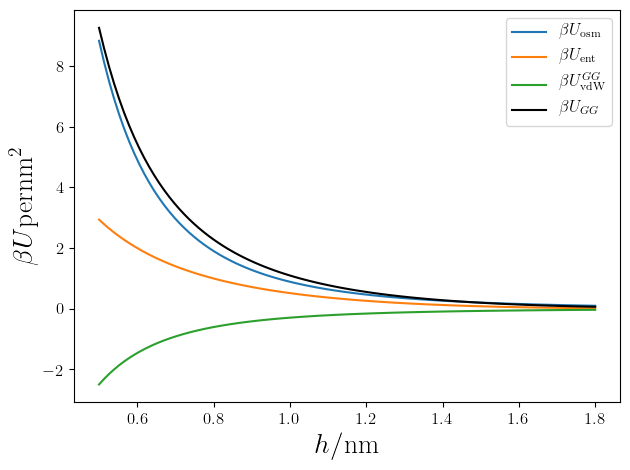

In [131]:
#graphene-graphene in solvent (rho=0.5,vdW,ligand_osm,ligand_ent,all)
R=7
coat_rho_G=0.4
hs=linspace(0.5,1.8,100)
U_layer_osms=[]
U_layer_elas=[]
U_vdWs=[]
U_alls=[]
for h in hs:
    ligand_layer=Ligand_Layer(ligand,chloroform,coat_rho_G,coat_rho_G,h,R)
    U_layer_osm=ligand_layer.cal_U_osm_W()
    U_layer_ela=ligand_layer.cal_U_ela_W()
    U_vdW=cal_U_vdW_GG(graphene,ligand_layer,chloroform,h)
    U_layer_osms.append(U_layer_osm)
    U_layer_elas.append(U_layer_ela)
    U_vdWs.append(U_vdW)
    U_alls.append(U_layer_osm+U_layer_ela+U_vdW)
plt.plot(hs,U_layer_osms,label=r'$\beta U_\mathrm{osm}$')
plt.plot(hs,U_layer_elas,label=r'$\beta U_\mathrm{ent}$')
plt.plot(hs,U_vdWs,label=r'$\beta U_\mathrm{vdW}^{GG}$')
plt.plot(hs,U_alls,color="black",label=r'$\beta U_{GG}$')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U \rm{per} \mathrm{nm^2}$",fontsize=20)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20)
plt.tight_layout()

## 2.2 graphene-particle in solvent

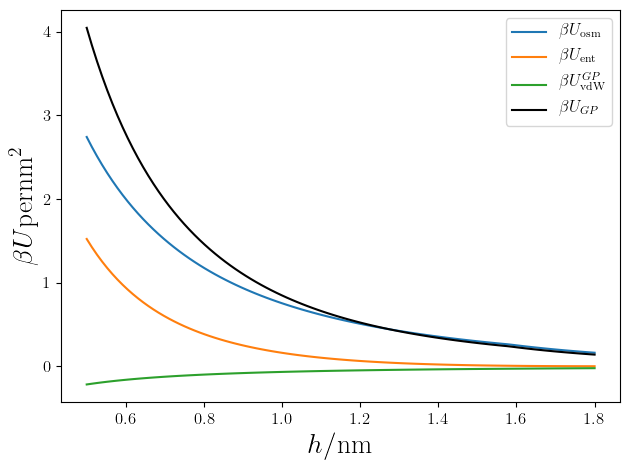

In [157]:
#graphene-particle in solvent (rho_G=0.5,rho_P=4.0,vdW,ligand_osm,ligand_ent,all)
R=7
coat_rho_G=0.4
coat_rho_P=3.0
hs=linspace(0.5,1.8,100)
U_layer_osms=[]
U_layer_elas=[]
U_vdWs=[]
U_alls=[]
for h in hs:
    area=2*sqrt(3)*R**2
    ligand_layer=Ligand_Layer(ligand,chloroform,coat_rho_G,coat_rho_P,h,R)
    U_layer_osm=ligand_layer.cal_U_osm_SW()/area
    U_layer_ela=ligand_layer.cal_U_ela_SW()/area
    U_vdW=cal_U_vdW_GP(graphene,Fe3O4,ligand_layer,chloroform,h,R)/area
    U_layer_osms.append(U_layer_osm)
    U_layer_elas.append(U_layer_ela)
    U_vdWs.append(U_vdW)
    U_alls.append(U_layer_osm+U_layer_ela+U_vdW)
plt.plot(hs,U_layer_osms,label=r'$\beta U_\mathrm{osm}$')
plt.plot(hs,U_layer_elas,label=r'$\beta U_\mathrm{ent}$')
plt.plot(hs,U_vdWs,label=r'$\beta U_\mathrm{vdW}^{GP}$')
plt.plot(hs,U_alls,color="black",label=r'$\beta U_{GP}$')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U \rm{per} \mathrm{nm^2}$",fontsize=20)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20)
plt.tight_layout()

## 2.3 graphene-graphene in air

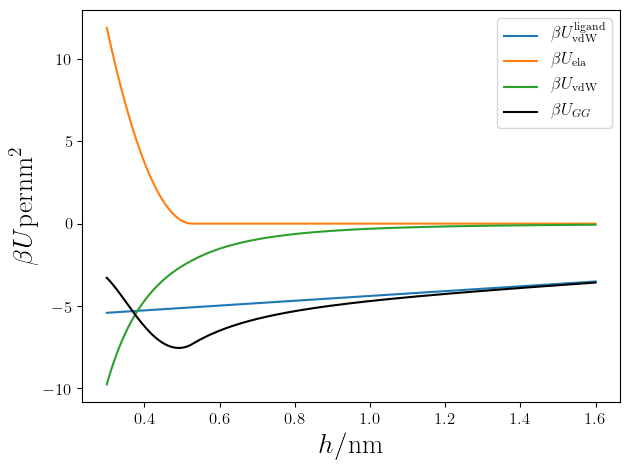

In [147]:
#graphene-graphene in air (rho=0.5,vdW,ligand_vdW,ligand_ela,all)
R=7
coat_rho_G=0.5
hs=linspace(0.3,1.6,200)
U_layer_vdws=[]
U_layer_coms=[]
U_vdWs=[]
U_alls=[]
for h in hs:
    ligand_layer=Ligand_Layer(ligand,chloroform,coat_rho_G,coat_rho_G,h,R)
    ligand_vdW=Ligand_vdW(ligand,coat_rho_G,coat_rho_G,h)
    U_layer_vdw=ligand_vdW.cal_WW_vdW(h)
    U_layer_com=ligand_layer.cal_U_com_W()
    U_vdW=cal_U_vdW_GG(graphene,ligand_layer,chloroform,h)
    U_layer_vdws.append(U_layer_vdw)
    U_layer_coms.append(U_layer_com)
    U_vdWs.append(U_vdW)
    U_alls.append(U_layer_vdw+U_layer_com+U_vdW)
plt.plot(hs,U_layer_vdws,label=r'$\beta U_\mathrm{vdW}^\mathrm{ligand}$')
plt.plot(hs,U_layer_coms,label=r'$\beta U_\mathrm{ela}$')
plt.plot(hs,U_vdWs,label=r'$\beta U_\mathrm{vdW}$')
plt.plot(hs,U_alls,color="black",label=r'$\beta U_{GG}$')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U \rm{per} \mathrm{nm^2}$",fontsize=20)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20)
plt.tight_layout()

## 2.4 graphene-particle in air

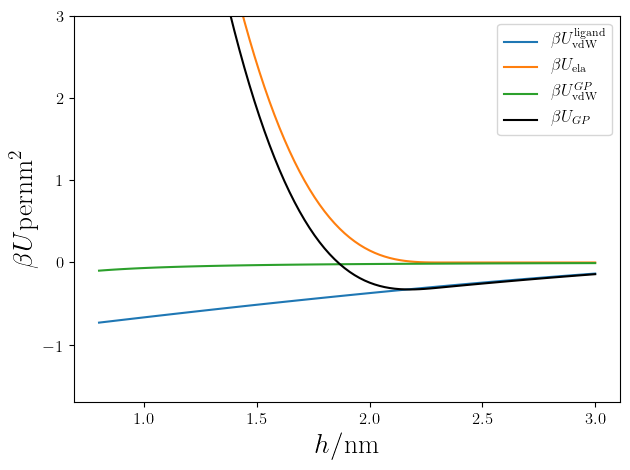

In [161]:
#graphene-particle in air (rho_G=0.5,rho_P=4.0,vdW,ligand_osm,ligand_ent,all)
R=7
coat_rho_G=0.4
coat_rho_P=4.0
hs=linspace(0.8,3,100)
U_layer_vdws=[]
U_layer_coms=[]
U_vdWs=[]
U_alls=[]
for h in hs:
    area=2*sqrt(3)*R**2
    ligand_layer=Ligand_Layer(ligand,chloroform,coat_rho_P,coat_rho_G,h,R)
    ligand_vdW=Ligand_vdW(ligand,coat_rho_P,coat_rho_G,h)
    U_layer_vdw=ligand_vdW.cal_SW_vdW(R)/area
    U_layer_com=ligand_layer.cal_U_com_SW()/area
    U_vdW=cal_U_vdW_GP(graphene,Fe3O4,ligand_layer,chloroform,h,R)/area
    U_layer_vdws.append(U_layer_vdw)
    U_layer_coms.append(U_layer_com)
    U_vdWs.append(U_vdW)
    U_alls.append(U_layer_vdw+U_layer_com+U_vdW)
plt.plot(hs,U_layer_vdws,label=r'$\beta U_\mathrm{vdW}^\mathrm{ligand}$')
plt.plot(hs,U_layer_coms,label=r'$\beta U_\mathrm{ela}$')
plt.plot(hs,U_vdWs,label=r'$\beta U_\mathrm{vdW}^{GP}$')
plt.plot(hs,U_alls,color="black",label=r'$\beta U_{GP}$')
plt.ylim(-1.7, 3)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U \rm{per} \mathrm{nm^2}$",fontsize=20)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20)
plt.tight_layout()

## 2.5 particle-particle in solvent

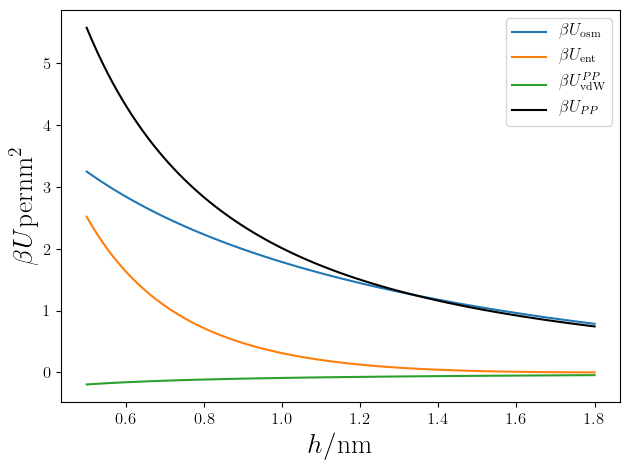

In [158]:
#particle-particle in solvent (rho_P=4.0,vdW,ligand_osm,ligand_ent,all)
R=7
coat_rho_P=4.0
hs=linspace(0.5,1.8,100)
U_layer_osms=[]
U_layer_elas=[]
U_vdWs=[]
U_alls=[]
for h in hs:
    area=2*sqrt(3)*R**2
    ligand_layer=Ligand_Layer(ligand,chloroform,coat_rho_P,coat_rho_P,h,R)
    U_layer_osm=ligand_layer.cal_U_osm_SS()/area
    U_layer_ela=ligand_layer.cal_U_ela_SS()/area
    U_vdW=cal_U_vdW_PP(Fe3O4,ligand_layer,h,R)/area
    U_layer_osms.append(U_layer_osm)
    U_layer_elas.append(U_layer_ela)
    U_vdWs.append(U_vdW)
    U_alls.append(U_layer_osm+U_layer_ela+U_vdW)
plt.plot(hs,U_layer_osms,label=r'$\beta U_\mathrm{osm}$')
plt.plot(hs,U_layer_elas,label=r'$\beta U_\mathrm{ent}$')
plt.plot(hs,U_vdWs,label=r'$\beta U_\mathrm{vdW}^{PP}$')
plt.plot(hs,U_alls,color="black",label=r'$\beta U_{PP}$')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U \rm{per} \mathrm{nm^2}$",fontsize=20)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20)
plt.tight_layout()

## 2.6 particle-particle in air

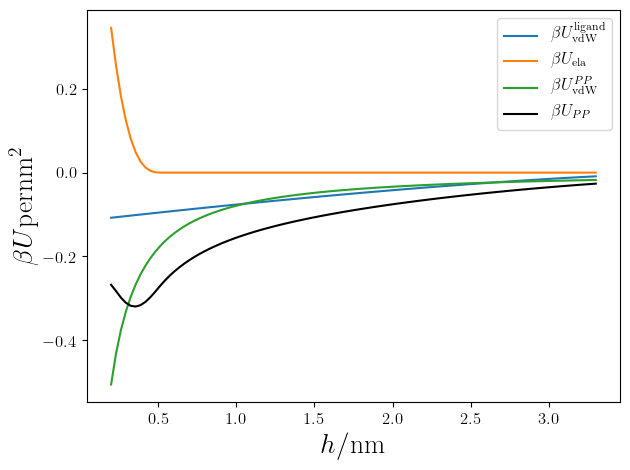

In [178]:
#-particle in air (rho_P=4.0,vdW,ligand_osm,ligand_ent,all)
R=7
coat_rho_P=0.5
hs=linspace(0.2,3.3,100)
data=hs
U_layer_vdws=[]
U_layer_coms=[]
U_vdWs=[]
U_alls=[]
for h in hs:
    area=2*sqrt(3)*R**2
    ligand_layer=Ligand_Layer(ligand,chloroform,coat_rho_P,coat_rho_P,h,R)
    ligand_vdW=Ligand_vdW(ligand,coat_rho_P,coat_rho_P,h)
    U_layer_vdw=ligand_vdW.cal_SS_vdW(R)/area
    U_layer_com=ligand_layer.cal_U_com_SS()/area
    U_vdW=cal_U_vdW_PP(Fe3O4,ligand_layer,h,R)/area
    U_layer_vdws.append(U_layer_vdw)
    U_layer_coms.append(U_layer_com)
    U_vdWs.append(U_vdW)
    U_alls.append(U_layer_vdw+U_layer_com+U_vdW)
plt.plot(hs,U_layer_vdws,label=r'$\beta U_\mathrm{vdW}^\mathrm{ligand}$')
plt.plot(hs,U_layer_coms,label=r'$\beta U_\mathrm{ela}$')
plt.plot(hs,U_vdWs,label=r'$\beta U_\mathrm{vdW}^{PP}$')
plt.plot(hs,U_alls,color="black",label=r'$\beta U_{PP}$')
#plt.ylim(-1.7, 3)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$\beta U \rm{per} \mathrm{nm^2}$",fontsize=20)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20)
plt.tight_layout()

## Section: critical grafting density 

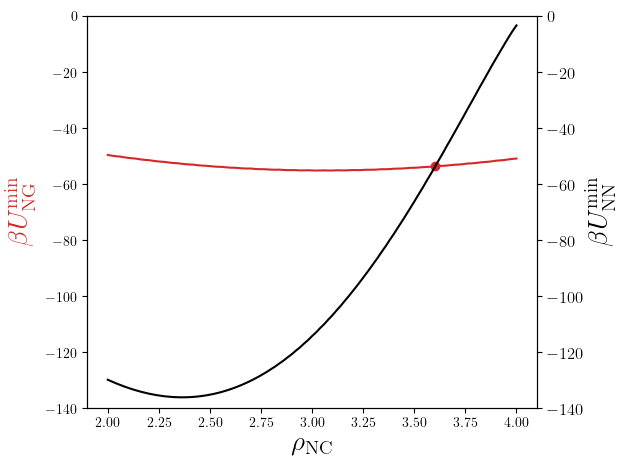

In [95]:
R=7
coat_rho_Ps=linspace(2.0,4.0,101)#51
coat_rho_Gs=[0.4]#[0.3,0.4,0.5,0.6]
hs=linspace(0.7,4.2,100)
U_WWs=[]
data=coat_rho_Ps
fig, ax1 = plt.subplots()
for coat_rho_G in coat_rho_Gs:
    U_SW_min=[]
    for coat_rho_P in coat_rho_Ps:
        U_SWs=[]
        for h in hs:
            U_SW=cal_U_GP_air(graphene,Fe3O4,ligand,air,coat_rho_P,coat_rho_G,h,R)
            U_SWs.append(U_SW)
        U_SW_min.append(min(U_SWs))
    data=column_stack((data,array(U_SW_min)))
    ax1.plot(coat_rho_Ps,U_SW_min,label=r"$\rho_{\rm NG}=%.2f$"%coat_rho_G,c='tab:red',zorder=1)
plt.ylim(-140,0)
plt.ylabel(r"$\beta U_{\rm NG}^{\rm min}$",fontsize=20,c='tab:red')
plt.xlabel(r"$\rho_{\rm NC}$",fontsize=20)
#plt.legend(fontsize=12,loc='lower right')
ax2 = ax1.twinx()
U1_min=[]
for coat_rho_P in coat_rho_Ps:
    U1s=[]
    U2s=[]
    U3s=[]
    for h in hs:
        U1=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)  
        U1s.append(U1)
    U1_min.append(min(U1s))
data=column_stack((data,array(U1_min)))
ax2.plot(coat_rho_Ps,U1_min,c='black',zorder=2)

plt.ylabel(r"$\beta U_{\rm NN}^{\rm min}$",fontsize=20)
plt.ylim(-140,0)
x=linspace(2.0,4.0,10000)
y1=interp(x,coat_rho_Ps,array(U_SW_min))
y2=interp(x,coat_rho_Ps,array(U1_min))
critical_rho=x[[argmin(abs(y1-y2))]]
critical_U=y1[[argmin(abs(y1-y2))]]
ax2.scatter(critical_rho,critical_U,c='tab:red',marker='o',zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

## Section: reversed grafting density

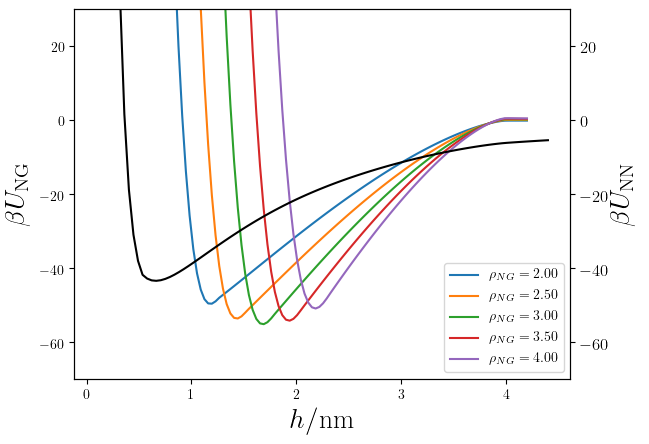

In [58]:
fig, ax1 = plt.subplots()


R=7
coat_rho_P=0.4
coat_rho_Gs=[2.0,2.5,3.0,3.5,4.0]
hs=linspace(0.7,4.2,100)
U_WWs=[]
#data=hs

for coat_rho_G in coat_rho_Gs:
    U_SWs=[]
    for h in hs:
        U_SW=cal_U_GP_air(graphene,Fe3O4,ligand,air,coat_rho_P,coat_rho_G,h,R)
        #U_SW=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)
        U_SWs.append(U_SW)
    ax1.plot(hs,U_SWs,label=r'$\rho_{NG}=%.2f$'%(coat_rho_G))
    #data=column_stack((data,array(U_SWs)))
plt.ylim(-70,30)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20) 
plt.ylabel(r"$\beta U_{\rm NG}$",fontsize=20)
plt.legend()    
    
coat_rhos=[0.5]
R=7
hs=linspace(0.1,4.4,100)
data=hs

ax2 = ax1.twinx()
for coat_rho in coat_rhos:
    U1s=[]
    U2s=[]
    U3s=[]
    for h in hs:
        U1=cal_U_PP_air(Fe3O4,ligand,air,coat_rho,h,R)  
        U1s.append(U1)
    ax2.plot(hs,U1s,c='black')    
    data=column_stack((data,array(U1s)))
plt.ylabel(r"$\beta U_{\rm NN}$",fontsize=20)

plt.ylim(-70,30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Section Revision: different particle sizes

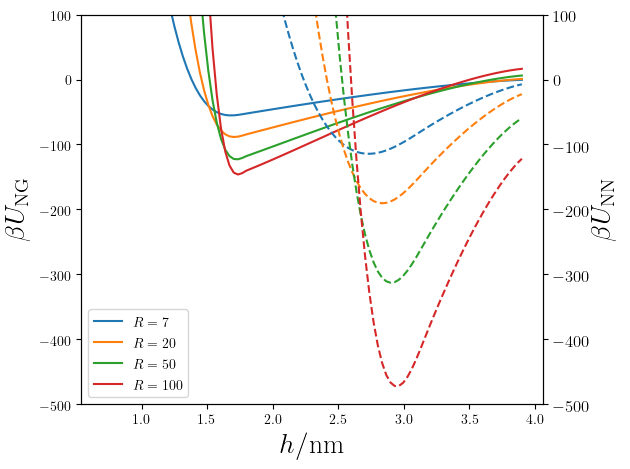

In [54]:
fig, ax1 = plt.subplots()

Rs=[7,20,50,100]
coat_rho_P=3.0
coat_rho_G=0.4
hs=linspace(0.7,3.9,100)
U_WWs=[]
data=hs
for R in Rs:
    area=2*sqrt(3)*R**2
    U_SWs=[]
    for h in hs:
        U_SW=cal_U_GP_air(graphene,Fe3O4,ligand,air,coat_rho_P,coat_rho_G,h,R)
        #U_SW=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)
        U_SWs.append(U_SW)
    ax1.plot(hs,array(U_SWs),label=r'$R=%d$'%(R))
    data=column_stack((data,array(U_SWs)))
plt.ylim(-500,100)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20) 
plt.ylabel(r"$\beta U_{\rm NG}$",fontsize=20)
plt.legend()    

plt.gca().set_prop_cycle(None)
hs=linspace(0.7,3.9,100)
ax2 = ax1.twinx()
for R in Rs:
    U1s=[]
    U2s=[]
    U3s=[]
    area=2*sqrt(3)*R**2
    for h in hs:
        U1=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)  
        U1s.append(U1)
    ax2.plot(hs,array(U1s),linestyle='dashed')    
    data=column_stack((data,array(U1s)))
plt.ylabel(r"$\beta U_{\rm NN}$",fontsize=20)

plt.ylim(-500,100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

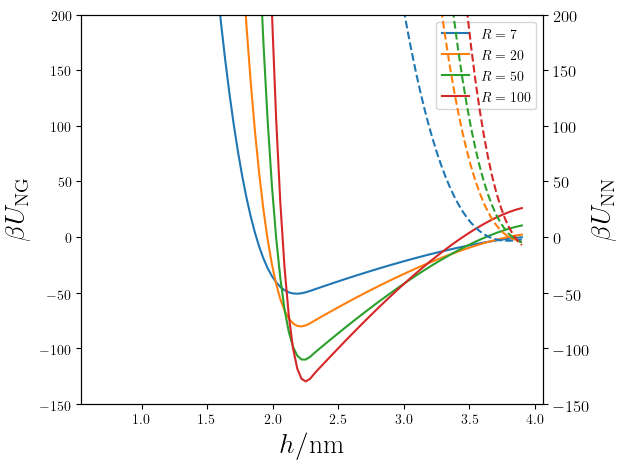

In [55]:
fig, ax1 = plt.subplots()

Rs=[7,20,50,100]
coat_rho_P=4.0
coat_rho_G=0.4
hs=linspace(0.7,3.9,100)
U_WWs=[]
data=hs
for R in Rs:
    area=2*sqrt(3)*R**2
    U_SWs=[]
    for h in hs:
        U_SW=cal_U_GP_air(graphene,Fe3O4,ligand,air,coat_rho_P,coat_rho_G,h,R)
        #U_SW=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)
        U_SWs.append(U_SW)
    ax1.plot(hs,array(U_SWs),label=r'$R=%d$'%(R))
    data=column_stack((data,array(U_SWs)))
plt.ylim(-150,200)
plt.xlabel(r"$h/\mathrm{nm}$",fontsize=20) 
plt.ylabel(r"$\beta U_{\rm NG}$",fontsize=20)
plt.legend()    
    
Rs=[7,15,20,30]
plt.gca().set_prop_cycle(None)
hs=linspace(0.7,3.9,100)
ax2 = ax1.twinx()
for R in Rs:
    U1s=[]
    U2s=[]
    U3s=[]
    area=2*sqrt(3)*R**2
    for h in hs:
        U1=cal_U_PP_air(Fe3O4,ligand,air,coat_rho_P,h,R)  
        U1s.append(U1)
    ax2.plot(hs,array(U1s),linestyle='dashed')    
    data=column_stack((data,array(U1s)))
plt.ylabel(r"$\beta U_{\rm NN}$",fontsize=20)

plt.ylim(-150,200)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("Figures/revision/figS17b.pdf",transparent=True)
savetxt("Figures/revision/figS17b.txt",data)